Buy Price: 8204.0, time: 2010-01-05T09:45:00.000000000
Sell Price: 8240.0, time: 2010-01-13T09:45:00.000000000
Trade completed

Buy Price: 8310.0, time: 2010-01-15T08:45:00.000000000
Sell Price: 8277.0, time: 2010-01-19T10:45:00.000000000
Trade completed

Buy Price: 7711.0, time: 2010-01-28T12:45:00.000000000
Sell Price: 7496.0, time: 2010-01-29T09:45:00.000000000
Trade completed

Buy Price: 7577.0, time: 2010-01-29T10:45:00.000000000
Sell Price: 7532.0, time: 2010-02-01T10:45:00.000000000
Trade completed

Buy Price: 7477.0, time: 2010-02-01T11:45:00.000000000
Sell Price: 7368.0, time: 2010-02-02T12:45:00.000000000
Trade completed

Buy Price: 7505.0, time: 2010-02-03T09:45:00.000000000
Sell Price: 7232.0, time: 2010-02-05T09:45:00.000000000
Trade completed

Buy Price: 7163.0, time: 2010-02-08T12:45:00.000000000
Sell Price: 7574.0, time: 2010-02-22T12:45:00.000000000
Trade completed

Buy Price: 7479.0, time: 2010-02-23T09:45:00.000000000
Sell Price: 7445.0, time: 2010-02-25T11:45:00.000

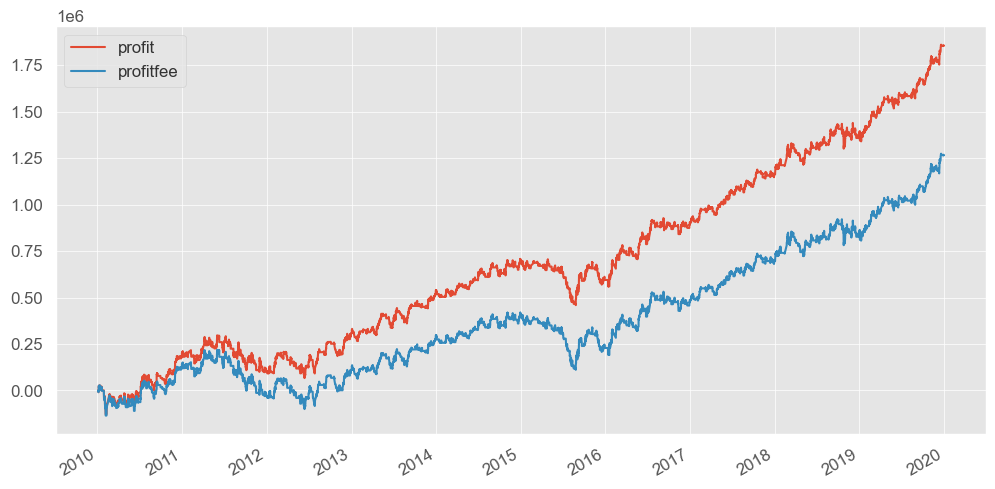

Profit :  1267200.0
Return :  1.2671999999999999
Max DrawDown :  0.26168990976210005
Caimar Ratio :  4.842372413793104
Trade Times :  492
Win Rate :  0.29878048780487804
Profit Factor :  1.3586550435865505


In [18]:
#### 進場 ＭＡＣＤ
#### 出場 ＭＡＣＤ＋ＲＳＩ


import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import quantstats
import os


plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

## 獨台指期 1 分K
df= pd.read_csv('TWF_Futures_Minute_Trade.txt')


## 整理資料
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time']) ## 中間要加空格 pandas 的用法
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)


rule = '3T' ## 3T 代表3個時間單位，在此就是3分鐘
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15) #先加 15 分鐘 以 9:00 單位開始

# 確認 9:03 及 9:06 的 open 是 9:01 及 9:04 的 open
Morning.resample(rule=rule, closed='right', label='right').first()[['open']].iloc[0:3]

# label='left' => 時間轉為左側時間
Morning.resample(rule=rule, closed='right', label='left').first()[['open']].iloc[0:3]

## 只抓日盤 =>時間只在8~13點之間
rule = '60T' ##以1個小時為單位

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']] #只要 open 的第一個值
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)

## 只抓夜盤 =>時間不能是8~13點之間
rule = '60T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()

## 完整資料: 日盤 + 夜盤
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)



## 選擇回測資料
# df_Morning['Month'] = df_Morning.index.map(lambda x: x.month)
# df_Morning['Weekday'] = df_Morning.index.map(lambda x: x.weekday)+1
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)


#將資料切成兩份
trainData = df_Morning[(df_Morning.index >= '2010-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()  # trend data
testData = df_Morning[(df_Morning.index >= '2020-1-1 00:00:00') & (df_Morning.index <= '2022-5-22 00:00:00')].copy()      # test data


## 取得結算日期
settlementDate_ = pd.read_csv('settlementDate.csv')#, encoding = 'ANSI')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']

#只抓取資料沒有 "W" 的(因為 W 代表周結算)
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

## 回測假設
# 換月轉倉：結算日當天直接平倉
# 進場限制：結算日當天不進場
# 報酬計算：200 * 點數
# 手續費+滑價：單邊 600元

#參數設定
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.04
rsi_period =14
ema_period_1 =20
ema_period_2 =60
signal_period =9


#MACD
trainData['EMA25'] = trainData['close'].ewm(span=25, adjust=False).mean()
trainData['EMA45'] = trainData['close'].ewm(span=45, adjust=False).mean()
trainData['MACD'] = trainData['EMA25'] - trainData['EMA45']
trainData['Signal'] = trainData['MACD'].ewm(span=6, adjust=False).mean()

# RSI函數
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

trainData['RSI']=rsi(trainData, periods = 22, ema = True)


#將時間序列數據轉換為NumPy數組
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]


##  做多

#建立存放資料的單位
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

#開始交易流程
for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 選擇 MACD 突破 Signal 
    entryLong = df_arr[i,8] > df_arr[i,9] 
    ### 結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### MACD 跌破 Signal 且 RSI < 50
    exitShort = df_arr[i,8] < df_arr[i,9] and df_arr[i,10] < 50

    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    #做多的狀態
    if BS == 'B':
      # 停損條件
      #以達成進場條件當作關鍵 K 棒，並設其最低點為停損點
      stopLoss  = df_arr[i,3] <= df_arr[t,2] 

    #還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        #確認進場&相關設定
        if entryLong and entryCondition:
            #更改狀態至做多
            BS = 'B'
            #紀錄進場時間
            t = i+1
            buy.append(t)
            print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    #進場開始計算未實現損益
    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        #近場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)

            #紀錄出場時間
            sell.append(i+1)

            #重置交易狀態
            BS = None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()


            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        #出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6))
plt.show()

equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy) 
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)


# 時間損益(年)
equity.index = pd.to_datetime(equity.index) #確保索引是datetime型態

In [19]:
#### 進場 ＭＡＣＤ＋ＲＳＩ
#### 出場 ＭＡＣＤ


import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import quantstats
import os


plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

## 獨台指期 1 分K
df= pd.read_csv('TWF_Futures_Minute_Trade.txt')


## 整理資料
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time']) ## 中間要加空格 pandas 的用法
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)


rule = '3T' ## 3T 代表3個時間單位，在此就是3分鐘
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15) #先加 15 分鐘 以 9:00 單位開始

# 確認 9:03 及 9:06 的 open 是 9:01 及 9:04 的 open
Morning.resample(rule=rule, closed='right', label='right').first()[['open']].iloc[0:3]

# label='left' => 時間轉為左側時間
Morning.resample(rule=rule, closed='right', label='left').first()[['open']].iloc[0:3]

## 只抓日盤 =>時間只在8~13點之間
rule = '60T' ##以1個小時為單位

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']] #只要 open 的第一個值
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)

## 只抓夜盤 =>時間不能是8~13點之間
rule = '60T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()

## 完整資料: 日盤 + 夜盤
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)



## 選擇回測資料
# df_Morning['Month'] = df_Morning.index.map(lambda x: x.month)
# df_Morning['Weekday'] = df_Morning.index.map(lambda x: x.weekday)+1
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)


#將資料切成兩份
trainData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()  # trend data
testData = df_Morning[(df_Morning.index >= '2020-1-1 00:00:00') & (df_Morning.index <= '2022-5-22 00:00:00')].copy()      # test data

'''
## 取得結算日期
settlementDate_ = pd.read_csv('settlementDate.csv')#, encoding = 'ANSI')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']

#只抓取資料沒有 "W" 的(因為 W 代表周結算)
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
'''
## 回測假設
# 換月轉倉：結算日當天直接平倉
# 進場限制：結算日當天不進場
# 報酬計算：200 * 點數
# 手續費+滑價：單邊 600元

#參數設定
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.04


# RSI函數
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

                           Strategy
-------------------------  ----------
Start Period               2010-01-04
End Period                 2019-12-30
Risk-Free Rate             0.0%
Time in Market             55.0%

Cumulative Return          126.72%
CAGR﹪                     5.82%

Sharpe                     0.3
Prob. Sharpe Ratio         98.2%
Smart Sharpe               0.29
Sortino                    0.43
Smart Sortino              0.42
Sortino/√2                 0.31
Smart Sortino/√2           0.3
Omega                      1.08

Max Drawdown               -26.17%
Longest DD Days            775
Volatility (ann.)          6.27%
Calmar                     0.22
Skew                       0.56
Kurtosis                   30.35

Expected Daily %           0.01%
Expected Monthly %         0.68%
Expected Yearly %          8.53%
Kelly Criterion            4.06%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.64%
Expected Shortfall (cVaR)  -0.64%

Max Consecutive Wins       12


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2011-06-02,2012-06-12,2013-07-15,775,-26.168991,-24.249385
2,2014-12-29,2015-08-26,2016-05-31,519,-21.688275,-21.054115
3,2010-01-11,2010-02-05,2010-07-12,182,-15.823278,-15.667575
4,2010-07-21,2010-09-02,2010-11-04,107,-9.268756,-8.679962
5,2013-07-16,2013-08-27,2013-09-12,58,-7.485667,-6.863227


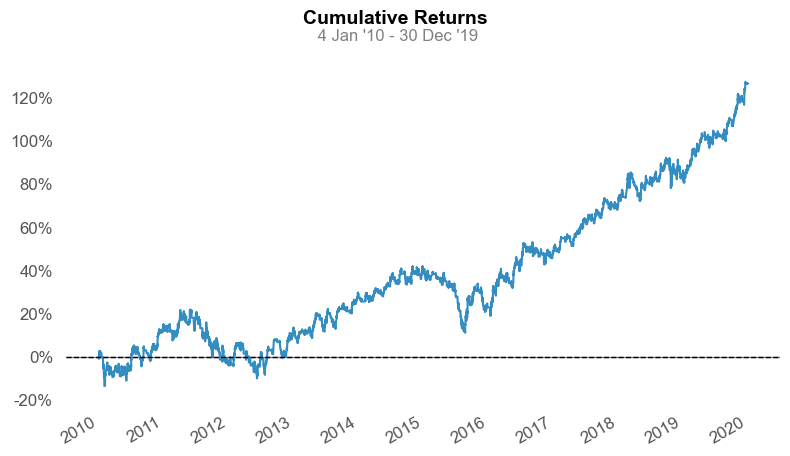

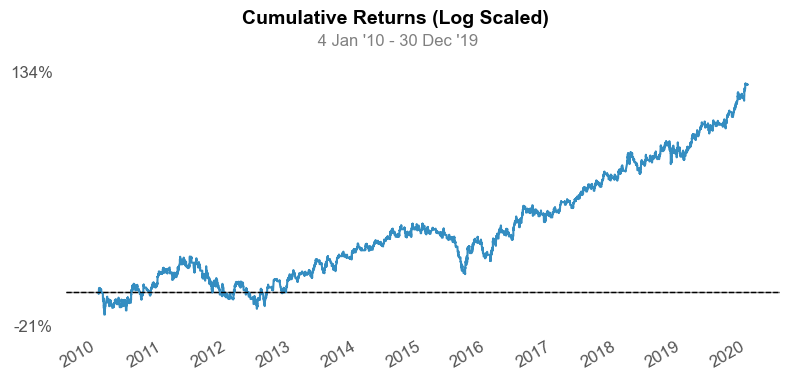

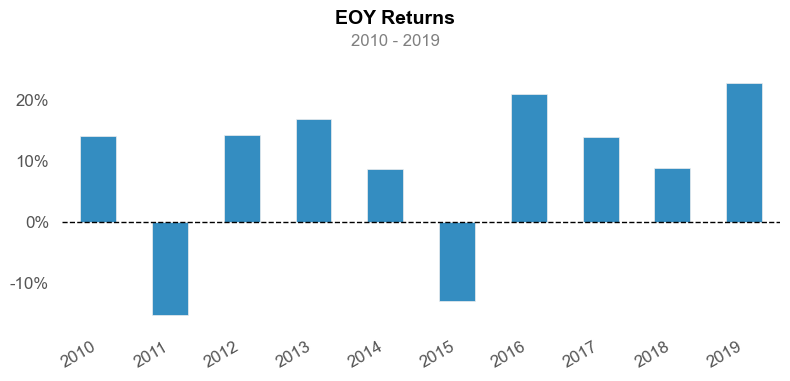

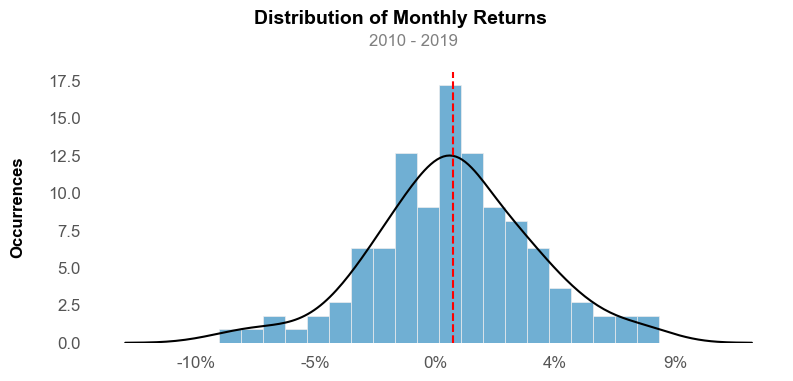

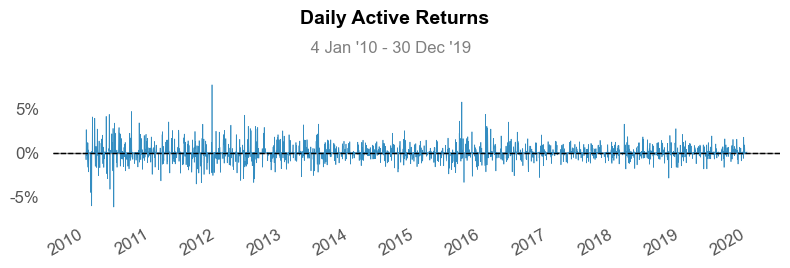

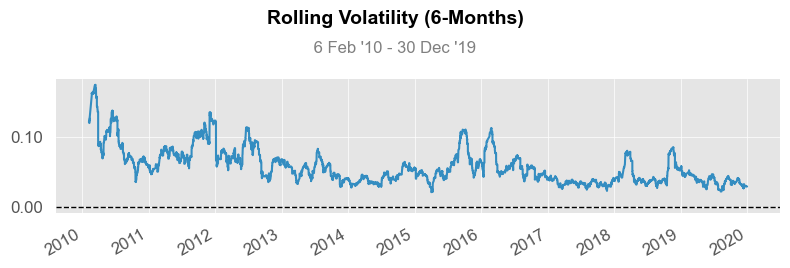

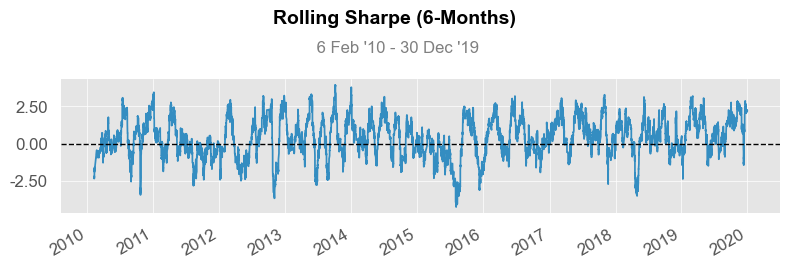

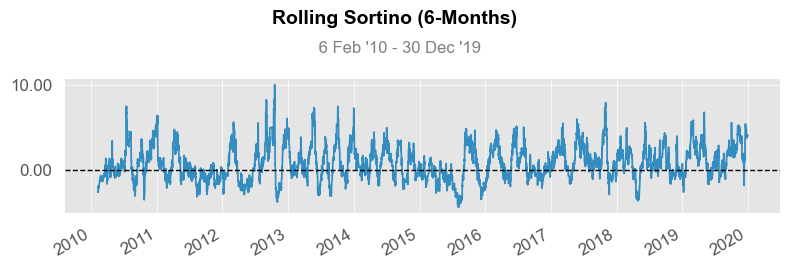

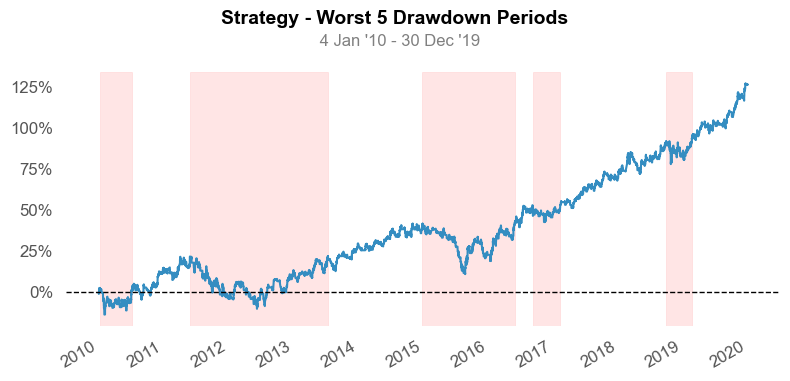

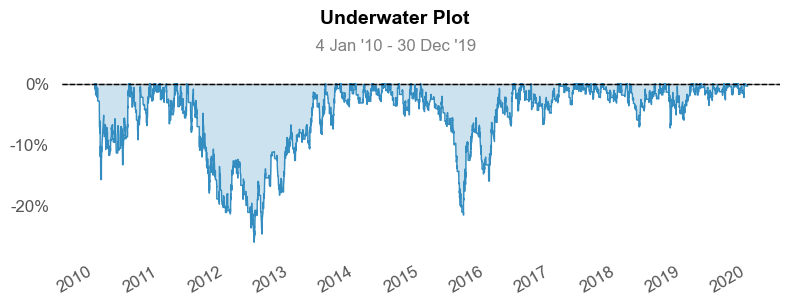

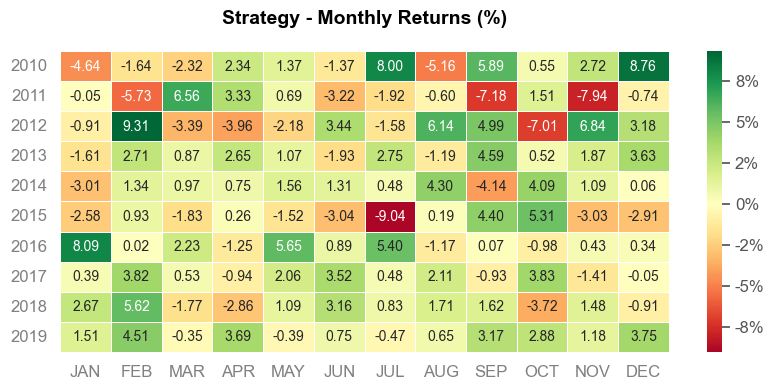

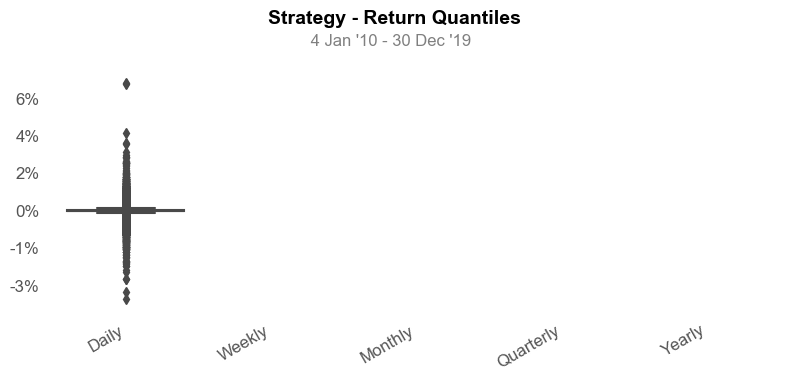

In [24]:
ret = equity['equity'].pct_change(periods=1).dropna()
#print(ret)
quantstats.reports.full(ret)

In [20]:
def get_ret_se(Close:pd.Series,Open:pd.Series,ema_period_1:int = 20,ema_period_2:int = 60,signal_period:int = 9,rsi_period:int = 14)->tuple:
    #MACD
    EMA_1 = Close.ewm(span=ema_period_1, adjust=False).mean()
    EMA_2 = Close.ewm(span=ema_period_2, adjust=False).mean()
    MACD = EMA_1 - EMA_2
    Signal = MACD.ewm(span=signal_period, adjust=False).mean()
    #RSI
    RSI=rsi(trainData, periods = rsi_period, ema = True)
    #bt
    pos = pd.Series(np.nan,index = trainData.index)
    pos[MACD>Signal] = 1
    pos[(MACD<Signal)&(RSI<50)] = 0
    pos = pos.ffill().fillna(0)
    
    Strategy_ret = Open.pct_change().shift(-1)*pos.shift(1)
    
    return Strategy_ret

In [21]:
def get_result(Close:pd.Series,Open:pd.Series,ema_period_1:int = 20,ema_period_2:int = 60,signal_period:int = 9,rsi_period:int = 14)->tuple:
    #MACD
    EMA_1 = Close.ewm(span=ema_period_1, adjust=False).mean()
    EMA_2 = Close.ewm(span=ema_period_2, adjust=False).mean()
    MACD = EMA_1 - EMA_2
    Signal = MACD.ewm(span=signal_period, adjust=False).mean()
    #RSI
    RSI=rsi(trainData, periods = rsi_period, ema = True)
    #bt
    pos = pd.Series(np.nan,index = trainData.index)
    pos[MACD>Signal] = 1
    pos[(MACD<Signal)&(RSI<50)] = 0
    pos = pos.ffill().fillna(0)
    
    Strategy_ret = Open.pct_change().shift(-1)*pos.shift(1)
    
    return ema_period_1,ema_period_2,signal_period,rsi_period,Strategy_ret.sum(),Strategy_ret.mean()/Strategy_ret.std()

In [22]:
search_pool = list()
for ema_period_1 in range(10,110,5):
    for ema_period_2 in range(10,110,5):
        for signal_period in range(3,33,3):
            for rsi_period in range(2,50,2):
                search_pool.append([ema_period_1,ema_period_2,signal_period,rsi_period])
print(len(search_pool))

96000


In [23]:
%%time
from joblib import Parallel, delayed
Strategy_ret_list = Parallel(n_jobs=-1)(delayed(get_result)(Close = trainData['close'],
                                                            Open = trainData['open'],
                                                            ema_period_1 = ema_period_1,
                                                            ema_period_2 = ema_period_2,
                                                            signal_period = signal_period,
                                                            rsi_period = rsi_period) for ema_period_1,ema_period_2,signal_period,rsi_period in search_pool)

/var/folders/x1/fvz51gz13nq7_l6khjwwpccc0000gn/T/ipykernel_64927/2930058339.py:17: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/x1/fvz51gz13nq7_l6khjwwpccc0000gn/T/ipykernel_64927/2930058339.py:17: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/x1/fvz51gz13nq7_l6khjwwpccc0000gn/T/ipykernel_64927/2930058339.py:17: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/x1/fvz51gz13nq7_l6khjwwpccc0000gn/T/ipykernel_64927/2930058339.py:17: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/x1/fvz51gz13nq7_l6khjwwpccc0000gn/T/ipykernel_64927/2930058339.py:17: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/x1/fvz51gz13nq7_l6khjwwpccc0000gn/T/ipykernel_64927/2930058339.py:17: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/x1/fvz51gz13nq7_l6khjwwpccc0000gn/T/ipykernel_64927/2930058339.py:17: RuntimeWarning: invalid value encountered in double_scalars

KeyboardInterrupt: 

In [ ]:
Strategy_ret_df = pd.DataFrame(Strategy_ret_list)
Strategy_ret_df.columns = ['ema_period_1','ema_period_2','signal_period','rsi_period','total_return','CV']
Strategy_ret_df.to_csv('參數結果.csv')

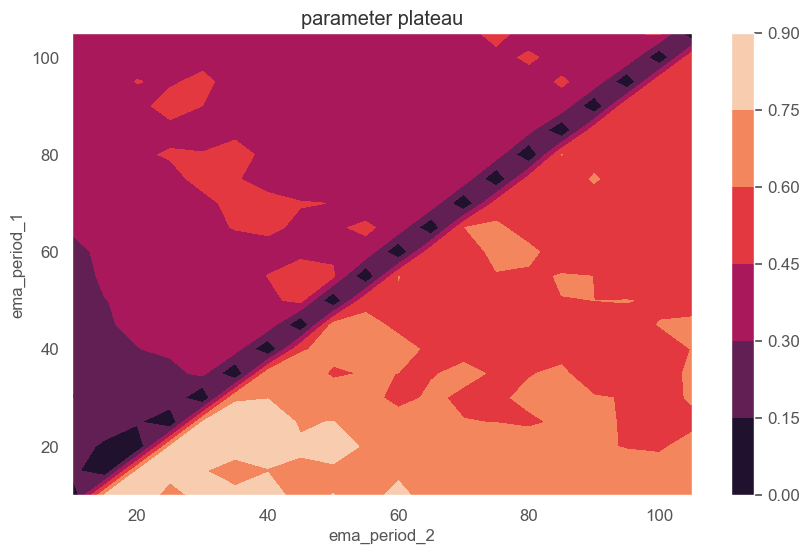

In [ ]:
result_df = Strategy_ret_df.groupby(['ema_period_1','ema_period_2'])['total_return'].max().unstack()
x, y = np.meshgrid(result_df.columns, result_df.index)
plt.contourf(x,y,result_df.values)
plt.colorbar()
plt.ylabel(result_df.index.name) # y label
plt.xlabel(result_df.columns.name) # x label
plt.title("parameter plateau")
plt.show()

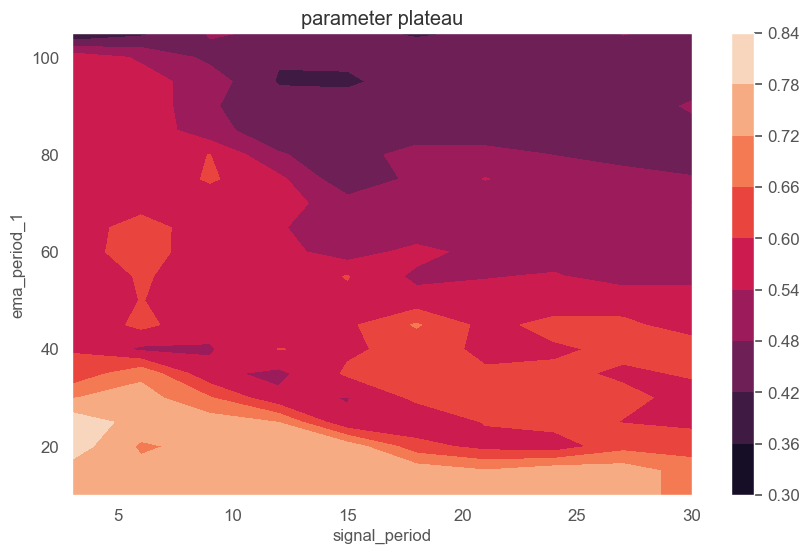

In [ ]:
result_df = Strategy_ret_df.groupby(['ema_period_1','signal_period'])['total_return'].max().unstack()
x, y = np.meshgrid(result_df.columns, result_df.index)
plt.contourf(x,y,result_df.values)
plt.colorbar()
plt.ylabel(result_df.index.name) # y label
plt.xlabel(result_df.columns.name) # x label
plt.title("parameter plateau")
plt.show()

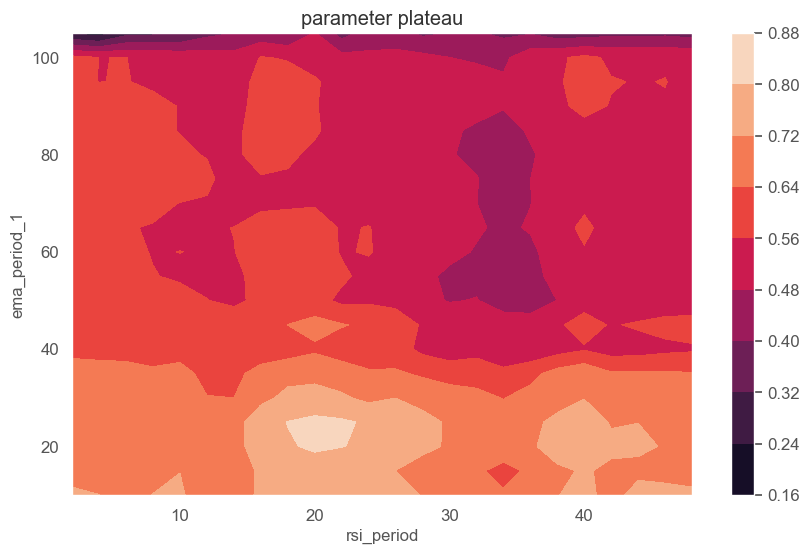

In [ ]:
result_df = Strategy_ret_df.groupby(['ema_period_1','rsi_period'])['total_return'].max().unstack()
x, y = np.meshgrid(result_df.columns, result_df.index)
plt.contourf(x,y,result_df.values)
plt.colorbar()
plt.ylabel(result_df.index.name) # y label
plt.xlabel(result_df.columns.name) # x label
plt.title("parameter plateau")
plt.show()

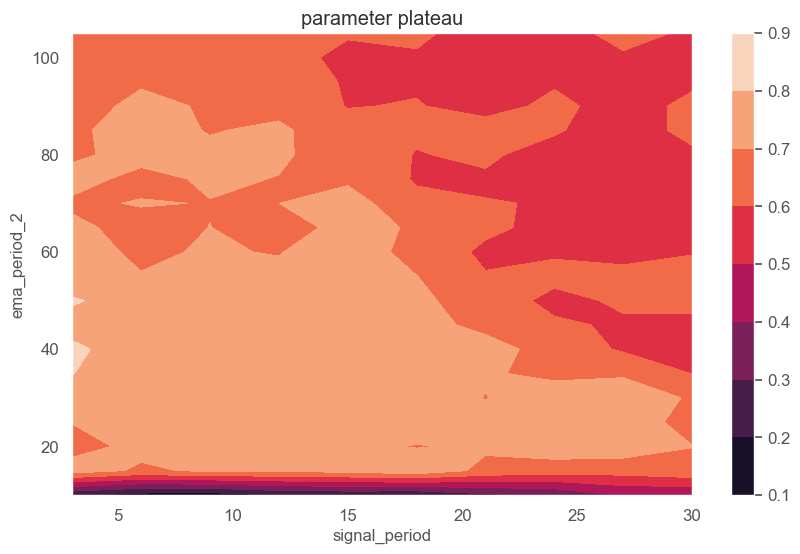

In [ ]:
result_df = Strategy_ret_df.groupby(['ema_period_2','signal_period'])['total_return'].max().unstack()
x, y = np.meshgrid(result_df.columns, result_df.index)
plt.contourf(x,y,result_df.values)
plt.colorbar()
plt.ylabel(result_df.index.name) # y label
plt.xlabel(result_df.columns.name) # x label
plt.title("parameter plateau")
plt.show()

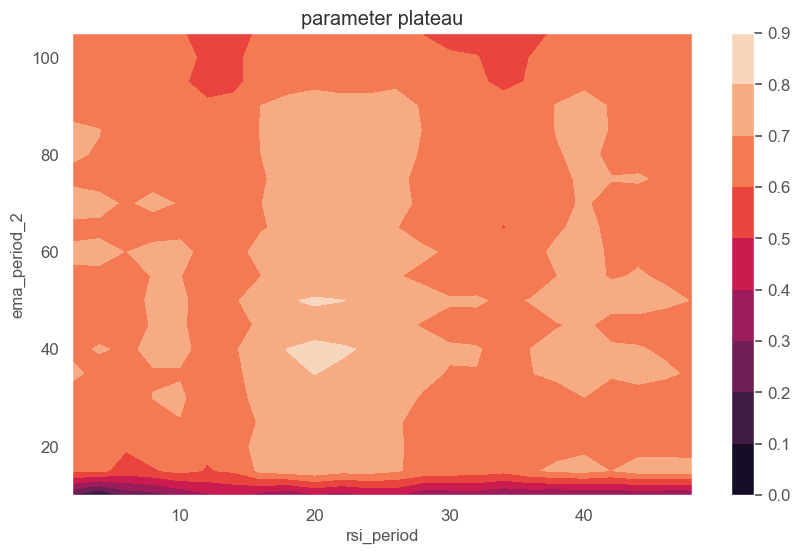

In [ ]:
result_df = Strategy_ret_df.groupby(['ema_period_2','rsi_period'])['total_return'].max().unstack()
x, y = np.meshgrid(result_df.columns, result_df.index)
plt.contourf(x,y,result_df.values)
plt.colorbar()
plt.ylabel(result_df.index.name) # y label
plt.xlabel(result_df.columns.name) # x label
plt.title("parameter plateau")
plt.show()

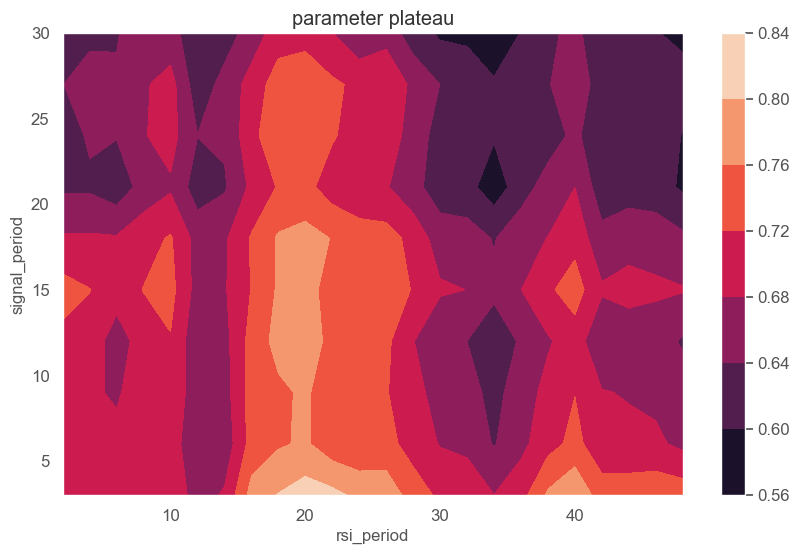

In [ ]:
result_df = Strategy_ret_df.groupby(['signal_period','rsi_period'])['total_return'].max().unstack()
x, y = np.meshgrid(result_df.columns, result_df.index)
plt.contourf(x,y,result_df.values)
plt.colorbar()
plt.ylabel(result_df.index.name) # y label
plt.xlabel(result_df.columns.name) # x label
plt.title("parameter plateau")
plt.show()

In [ ]:
Strategy_ret_df.loc[Strategy_ret_df['total_return'].idxmax()]

ema_period_1     25.000000
ema_period_2     40.000000
signal_period     3.000000
rsi_period       20.000000
total_return      0.819190
CV                0.024773
Name: 15849, dtype: float64

In [ ]:
Strategy_ret_df.loc[Strategy_ret_df['CV'].idxmax()]

ema_period_1     10.000000
ema_period_2     70.000000
signal_period    15.000000
rsi_period        2.000000
total_return      0.735659
CV                0.025152
Name: 2976, dtype: float64

In [ ]:
Strategy_ret = get_ret_se(Close = trainData['close'],
                          Open = trainData['open'],
                          ema_period_1 = 5,
                          ema_period_2 = 15,
                          signal_period = 5,
                          rsi_period = 45)

<Axes: >

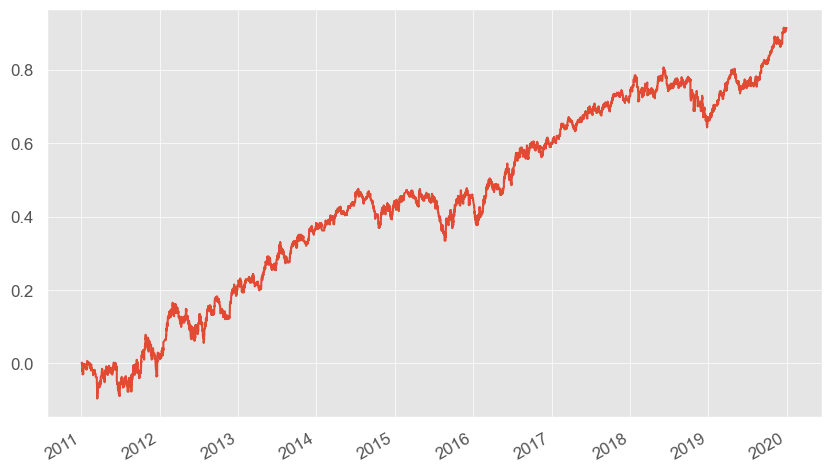

In [ ]:
Strategy_ret.cumsum().plot()